# **Global Terrorism Database (GTD) - Exploratory Data Analysis**

In [2]:
%config Completer.use_jedi = False

In [3]:
### importing required libraries 
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from geopy.geocoders import Nominatim
import langid
import multiprocessing
from multiprocessing import Pool

In [70]:
### Setting plotting background
sns.set_style('darkgrid')
plt.rcParams['font.size'] = 11
plt.rcParams['figure.facecolor'] = '#00000000'

In [5]:
import warnings
warnings.filterwarnings("ignore")

##   **1. Data Preparation and Cleaning** 
a.   Loading the dataset into pandas dataframe <br>
b.   Checking the info. about data <br>
c.   Feature selection <br>
d.   Fixing the missing & incorrect values (multiprocessing applied)<br>
e.   Creating new feature columns if required.<br>

### a) Loading the dataset into pandas dataframe

In [6]:
### reading the csv file 
GTA_data  = pd.read_csv('/kaggle/input/gtd/globalterrorismdb_0718dist.csv',encoding = "ISO-8859-1")

In [7]:
### creating a copy of orginal data 
data = GTA_data.copy()

In [8]:
data.head()

,eventid,iyear,imonth,iday,approxdate,extended,resolution,country,country_txt,region,...,addnotes,scite1,scite2,scite3,dbsource,INT_LOG,INT_IDEO,INT_MISC,INT_ANY,related
0,197000000001,1970,7,2,NaN,0,NaN,58,Dominican Republic,2,...,NaN,NaN,NaN,NaN,PGIS,0,0,0,0,NaN
1,197000000002,1970,0,0,NaN,0,NaN,130,Mexico,1,...,NaN,NaN,NaN,NaN,PGIS,0,1,1,1,NaN
2,197001000001,1970,1,0,NaN,0,NaN,160,Philippines,5,...,NaN,NaN,NaN,NaN,PGIS,-9,-9,1,1,NaN
3,197001000002,1970,1,0,NaN,0,NaN,78,Greece,8,...,NaN,NaN,NaN,NaN,PGIS,-9,-9,1,1,NaN
4,197001000003,1970,1,0,NaN,0,NaN,101,Japan,4,...,NaN,NaN,NaN,NaN,PGIS,-9,-9,1,1,NaN


#### **b) Checking the info. about data and columns**

In [9]:
data.shape

(181691, 135)

In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 181691 entries, 0 to 181690
Columns: 135 entries, eventid to related
dtypes: float64(55), int64(22), object(58)
memory usage: 187.1+ MB


In [56]:
data.columns

Index(['eventid', 'iyear', 'imonth', 'iday', 'approxdate', 'extended',
       'resolution', 'country', 'country_txt', 'region',
       ...
       'addnotes', 'scite1', 'scite2', 'scite3', 'dbsource', 'INT_LOG',
       'INT_IDEO', 'INT_MISC', 'INT_ANY', 'related'],
      dtype='object', length=135)

In [12]:
""" Since the data consists of 135 feature columns I am checking the amount of missing/null values for each features which consists of 
                    more than  30% of missing values.  """
data.isna().sum()

eventid            0
iyear              0
imonth             0
iday               0
approxdate    172452
               ...  
INT_LOG            0
INT_IDEO           0
INT_MISC           0
INT_ANY            0
related       156653
Length: 135, dtype: int64

<AxesSubplot:>

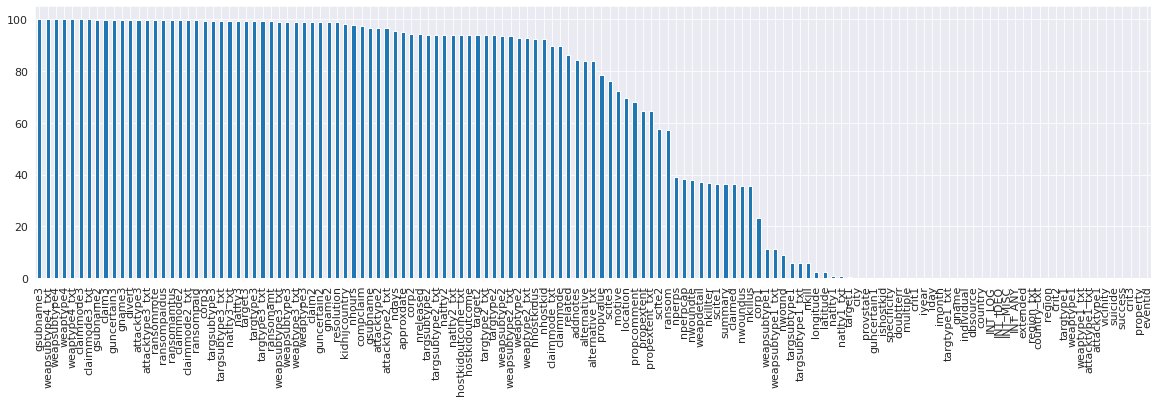

In [72]:
###  Percentage of missing values per columns
plt.figure(figsize=(20, 5))
Missing_values_percent = ((data.isna().sum()/data.shape[0])*100).sort_values(ascending=False)
Missing_values_percent.plot(kind = 'bar')

In [14]:
print(f'The number of columns which have more than 30% of null values are:{ len(Missing_values_percent [Missing_values_percent >= 30])}')

The number of columns which have more than 30% of null values are:87


In [15]:
#### name of columns that consists of less than 30% of null values
Missing_values_percent [Missing_values_percent <= 30].index

Index(['eventid', 'iyear', 'imonth', 'iday', 'extended', 'country',
       'country_txt', 'region', 'region_txt', 'provstate', 'city', 'latitude',
       'longitude', 'specificity', 'vicinity', 'crit1', 'crit2', 'crit3',
       'doubtterr', 'multiple', 'success', 'suicide', 'attacktype1',
       'attacktype1_txt', 'targtype1', 'targtype1_txt', 'targsubtype1',
       'targsubtype1_txt', 'corp1', 'target1', 'natlty1', 'natlty1_txt',
       'gname', 'guncertain1', 'individual', 'weaptype1', 'weaptype1_txt',
       'weapsubtype1', 'weapsubtype1_txt', 'nkill', 'nwound', 'property',
       'ishostkid', 'dbsource', 'INT_LOG', 'INT_IDEO', 'INT_MISC', 'INT_ANY'],
      dtype='object')

In [16]:
#### We are dropping all the columns that consits of more than 30% of null values.  
# perc = 30
# thresh_count =  int(((100-perc)/100)*data.shape[0] + 1)
# data.dropna(axis=1, thresh=thresh_count,inplace = True)

#### **c) Feature Selections**

In [17]:
###  Selecting only required features from the above data for further analysis 
keep_cols = ['eventid', 'iyear', 'imonth', 'iday', 'extended','country_txt','region_txt','city', 'latitude',
       'longitude','success','attacktype1_txt', 'targtype1_txt','corp1', 'target1','natlty1_txt','targsubtype1_txt',
       'gname','weaptype1_txt','nkill','nwound','property']

### creating a new dataframe with selected features 
data_new = data[keep_cols]

In [18]:
### Updating the headers
data_new.rename(columns = {'iyear':'year','imonth':'month','iday':'day','country_txt':'country_name','region_txt':'region',
                           'attacktype1_txt':'attack_type','targtype1_txt':'victim_cata','target1':'specific_victim','targsubtype1_txt':'victim_subtype_cata',
                           'corp1':'entity_name','natlty1_txt':'victim_nationaliy','gname':'perpetrator_group','weaptype1_txt':'weapon','nkill':'num_fatalities',
                           'nwound':'num_injured'},inplace = True)

In [19]:
data_new.head()

,eventid,year,month,day,extended,country_name,region,city,latitude,longitude,...,victim_cata,entity_name,specific_victim,victim_nationaliy,victim_subtype_cata,perpetrator_group,weapon,num_fatalities,num_injured,property
0,197000000001,1970,7,2,0,Dominican Republic,Central America & Caribbean,Santo Domingo,18.456792,-69.951164,...,Private Citizens & Property,NaN,Julio Guzman,Dominican Republic,Named Civilian,MANO-D,Unknown,1.0,0.0,0
1,197000000002,1970,0,0,0,Mexico,North America,Mexico city,19.371887,-99.086624,...,Government (Diplomatic),Belgian Ambassador Daughter,"Nadine Chaval, daughter",Belgium,"Diplomatic Personnel (outside of embassy, cons...",23rd of September Communist League,Unknown,0.0,0.0,0
2,197001000001,1970,1,0,0,Philippines,Southeast Asia,Unknown,15.478598,120.599741,...,Journalists & Media,Voice of America,Employee,United States,Radio Journalist/Staff/Facility,Unknown,Unknown,1.0,0.0,0
3,197001000002,1970,1,0,0,Greece,Western Europe,Athens,37.997490,23.762728,...,Government (Diplomatic),NaN,U.S. Embassy,United States,Embassy/Consulate,Unknown,Explosives,NaN,NaN,1
4,197001000003,1970,1,0,0,Japan,East Asia,Fukouka,33.580412,130.396361,...,Government (Diplomatic),NaN,U.S. Consulate,United States,Embassy/Consulate,Unknown,Incendiary,NaN,NaN,1


In [20]:
data_new.describe()

,eventid,year,month,day,extended,latitude,longitude,success,num_fatalities,num_injured,property
count,1.816910e+05,181691.000000,181691.000000,181691.000000,181691.000000,177135.000000,1.771340e+05,181691.000000,171378.000000,165380.000000,181691.000000
mean,2.002705e+11,2002.638997,6.467277,15.505644,0.045346,23.498343,-4.586957e+02,0.889598,2.403272,3.167668,-0.544556
std,1.325957e+09,13.259430,3.388303,8.814045,0.208063,18.569242,2.047790e+05,0.313391,11.545741,35.949392,3.122889
min,1.970000e+11,1970.000000,0.000000,0.000000,0.000000,-53.154613,-8.618590e+07,0.000000,0.000000,0.000000,-9.000000
25%,1.991021e+11,1991.000000,4.000000,8.000000,0.000000,11.510046,4.545640e+00,1.000000,0.000000,0.000000,0.000000
50%,2.009022e+11,2009.000000,6.000000,15.000000,0.000000,31.467463,4.324651e+01,1.000000,0.000000,0.000000,1.000000
75%,2.014081e+11,2014.000000,9.000000,23.000000,0.000000,34.685087,6.871033e+01,1.000000,2.000000,2.000000,1.000000
max,2.017123e+11,2017.000000,12.000000,31.000000,1.000000,74.633553,1.793667e+02,1.000000,1570.000000,8191.000000,1.000000


### **d) Missing & incorrect values.**
  #### **1.Dealing with incorrect values**

In [21]:
### checking out the columns that contains 0 values for day and month 
data_new[(data_new.month == 0) | (data_new.day ==0)].head()

,eventid,year,month,day,extended,country_name,region,city,latitude,longitude,...,victim_cata,entity_name,specific_victim,victim_nationaliy,victim_subtype_cata,perpetrator_group,weapon,num_fatalities,num_injured,property
1,197000000002,1970,0,0,0,Mexico,North America,Mexico city,19.371887,-99.086624,...,Government (Diplomatic),Belgian Ambassador Daughter,"Nadine Chaval, daughter",Belgium,"Diplomatic Personnel (outside of embassy, cons...",23rd of September Communist League,Unknown,0.0,0.0,0
2,197001000001,1970,1,0,0,Philippines,Southeast Asia,Unknown,15.478598,120.599741,...,Journalists & Media,Voice of America,Employee,United States,Radio Journalist/Staff/Facility,Unknown,Unknown,1.0,0.0,0
3,197001000002,1970,1,0,0,Greece,Western Europe,Athens,37.997490,23.762728,...,Government (Diplomatic),NaN,U.S. Embassy,United States,Embassy/Consulate,Unknown,Explosives,NaN,NaN,1
4,197001000003,1970,1,0,0,Japan,East Asia,Fukouka,33.580412,130.396361,...,Government (Diplomatic),NaN,U.S. Consulate,United States,Embassy/Consulate,Unknown,Incendiary,NaN,NaN,1
96,197003000001,1970,3,0,0,Philippines,Southeast Asia,Manila,14.596051,120.978666,...,Government (Diplomatic),NaN,U.S. Embassy,United States,Embassy/Consulate,Unknown,Explosives,0.0,0.0,1


In [22]:
data_new['month'].value_counts().sort_values(ascending= False),data_new['day'].value_counts().sort_values(ascending= False)

(5     16875
 7     16268
 8     15800
 10    15563
 6     15359
 3     15257
 4     15152
 1     14936
 11    14906
 9     14180
 2     13879
 12    13496
 0        20
 Name: month, dtype: int64,
 15    6500
 1     6344
 4     6153
 16    6112
 10    6064
 9     6057
 13    6043
 14    6028
 28    6027
 12    6012
 3     6011
 7     5997
 19    5973
 2     5954
 27    5937
 11    5936
 20    5930
 18    5880
 25    5875
 8     5859
 17    5852
 5     5844
 21    5827
 26    5823
 22    5799
 23    5782
 6     5781
 24    5752
 29    5507
 30    5046
 31    3095
 0      891
 Name: day, dtype: int64)

In [23]:
### replacing month 0 values with month 12
data_new.month.replace(0,5 , inplace = True)

### replacing day 0 values with day 31
data_new.day.replace(0,15, inplace = True)

#### **2. Dealing with Missing values**

In [24]:
missing_values = ((data_new.isna().sum()/data_new.shape[0])*100).sort_values(ascending= False)
missing_values

entity_name            23.418882
num_injured             8.977330
victim_subtype_cata     5.709144
num_fatalities          5.676120
longitude               2.508104
latitude                2.507554
victim_nationaliy       0.858050
specific_victim         0.350045
city                    0.238867
eventid                 0.000000
weapon                  0.000000
perpetrator_group       0.000000
attack_type             0.000000
victim_cata             0.000000
year                    0.000000
success                 0.000000
region                  0.000000
country_name            0.000000
extended                0.000000
day                     0.000000
month                   0.000000
property                0.000000
dtype: float64

In [25]:
data_new[['num_injured','num_fatalities']] = data_new[['num_injured','num_fatalities']].fillna(method='ffill')
data_new[['entity_name','specific_victim','victim_nationaliy']] =data_new[['entity_name','specific_victim','victim_nationaliy']].fillna('Unknown')
data_new['victim_subtype_cata'] = data_new['victim_subtype_cata'].fillna('Unnamed Civilian/Unspecified')

In [26]:
print(data_new[data_new.city == 'Unknown']['city'].count())
print(data_new[data_new.city == 'unknown']['city'].count())
print(len(data_new[data_new.city.isna() == True]['city']))

9775
47
434


In [27]:
data_new.city = data_new.city.replace('unknown','Unknown')
data_new['city'] = data_new['city'].fillna('Unknown')
percent_city_unknown = len(data_new[data_new.city =='Unknown'])/len(data_new)*100
print(f'The percentage of total unkown values in the city columns {percent_city_unknown}')

The percentage of total unkown values in the city columns 5.644748501576853


In [28]:
data_new.city.value_counts()

Unknown      10256
Baghdad       7589
Karachi       2652
Lima          2359
Mosul         2265
             ...  
Hotwag           1
Ostend           1
Balughata        1
Jikoyi           1
Kubentog         1
Name: city, Length: 36673, dtype: int64

In [29]:
unknown_city_data = data_new[(data_new['longitude'].isna()== False) & (data_new['latitude'].isna()== False) & (data_new['city'] == 'Unknown')][['longitude','latitude','city']]
unknown_city_data.head()

,longitude,latitude,city
2,120.599741,15.478598,Unknown
705,49.536102,37.146795,Unknown
1007,-6.086832,54.552254,Unknown
1085,119.583330,23.583333,Unknown
1222,121.965256,17.092014,Unknown


In [30]:
print(f'The length of data which have unknown value for city column whose latitude and longitude is present is {len(unknown_city_data)}')

The length of data which have unknown value for city column whose latitude and longitude is present is 7961


#### Multiprocessing 

In [31]:
# geolocator = Nominatim(user_agent="http")

# def update_city(row):
#     try:
#         Longitude = str(row['longitude'])
#         Latitude = str(row['latitude'])
#         location = geolocator.reverse(Latitude+","+Longitude, exactly_one=True)
#         address = location.raw['address']
#         city = address.get('city', '')

#     ### Selecting the city name only in english language
#         if langid.classify(city)[0] =='en':
#             row['city'] = row['city'].replace('Unknown', str(city))
#         else:
#             row['city'] = row['city']
#         return row
    
#     except Exception as e:
#         print(e)
        
        
# def update_city2(df):
#     df2 = df.apply(update_city , axis = 1)
#     return df2


# df1 = unknown_city_data[0:2000]
# df2 = unknown_city_data[2000:4000]   
# #df1 = unknown_city_data[4000:6000]
# #df2 = unknown_city_data[6000:]   

# if __name__ == '__main__':
#     df = unknown_city_data
#     p = Pool()
#     result = p.map(update_city2,[df1,df2
#                                  ])
#     p.close()
#     p.join()
#     print(result)

In [32]:
#pd.concat(result,axis =0).to_csv('Geocoder_city.csv')

In [33]:
# df1 = unknown_city_data[4000:6000]
# df2 = unknown_city_data[6000:]   

# if __name__ == '__main__':
#     df = unknown_city_data
#     p = Pool()
#     result = p.map(update_city2,[df1,df2
#                                  ])
#     p.close()
#     p.join()
#     print(result)

In [34]:
#pd.concat(result,axis =0).to_csv('Geocoder_city1.csv')

In [35]:
#Geocoder_data_part1 = pd.read_csv('./Geocoder_city.csv')
#Geocoder_data_part2 = pd.read_csv('./Geocoder_city1.csv')

Geocoder_data_part1 = pd.read_csv('/kaggle/input/output-data/Geocoder_city.csv')
Geocoder_data_part2 = pd.read_csv('/kaggle/input/output-data/Geocoder_city1.csv')

city_data = pd.concat([Geocoder_data_part1,Geocoder_data_part2],axis = 0).set_index('Unnamed: 0')
city_data = city_data[(city_data.city !='Unknown') & (city_data.city.notnull())]

In [36]:
city_data.head()

,longitude,latitude,city
Unnamed: 0,,,
2,120.599741,15.478598,Tarlac City
1007,-6.086832,54.552254,Lisburn
3393,121.972109,6.705778,Isabela
3628,121.972109,6.705778,Isabela
6340,140.717000,-2.533000,Jayapura


In [37]:
def change_city(df1,df2):
    for i in df2.index:
        if i in df1.index:
            df1.loc[i, ['city']] = df2.loc[i,'city'] 
    return df1

In [38]:
change_city(data_new,city_data).head(5)

,eventid,year,month,day,extended,country_name,region,city,latitude,longitude,...,victim_cata,entity_name,specific_victim,victim_nationaliy,victim_subtype_cata,perpetrator_group,weapon,num_fatalities,num_injured,property
0,197000000001,1970,7,2,0,Dominican Republic,Central America & Caribbean,Santo Domingo,18.456792,-69.951164,...,Private Citizens & Property,Unknown,Julio Guzman,Dominican Republic,Named Civilian,MANO-D,Unknown,1.0,0.0,0
1,197000000002,1970,5,15,0,Mexico,North America,Mexico city,19.371887,-99.086624,...,Government (Diplomatic),Belgian Ambassador Daughter,"Nadine Chaval, daughter",Belgium,"Diplomatic Personnel (outside of embassy, cons...",23rd of September Communist League,Unknown,0.0,0.0,0
2,197001000001,1970,1,15,0,Philippines,Southeast Asia,Tarlac City,15.478598,120.599741,...,Journalists & Media,Voice of America,Employee,United States,Radio Journalist/Staff/Facility,Unknown,Unknown,1.0,0.0,0
3,197001000002,1970,1,15,0,Greece,Western Europe,Athens,37.997490,23.762728,...,Government (Diplomatic),Unknown,U.S. Embassy,United States,Embassy/Consulate,Unknown,Explosives,1.0,0.0,1
4,197001000003,1970,1,15,0,Japan,East Asia,Fukouka,33.580412,130.396361,...,Government (Diplomatic),Unknown,U.S. Consulate,United States,Embassy/Consulate,Unknown,Incendiary,1.0,0.0,1


In [39]:
data_new.city.value_counts()

Unknown           9949
Baghdad           7589
Karachi           2652
Lima              2362
Mosul             2265
                  ... 
Montalban            1
Enugu Ukwu           1
Sukanguri            1
Fila el Atillo       1
Kubentog             1
Name: city, Length: 36690, dtype: int64

In [40]:
((data_new.isna().sum()/data_new.shape[0])*100).sort_values(ascending= False)

longitude              2.508104
latitude               2.507554
eventid                0.000000
victim_cata            0.000000
num_injured            0.000000
num_fatalities         0.000000
weapon                 0.000000
perpetrator_group      0.000000
victim_subtype_cata    0.000000
victim_nationaliy      0.000000
specific_victim        0.000000
entity_name            0.000000
attack_type            0.000000
year                   0.000000
success                0.000000
city                   0.000000
region                 0.000000
country_name           0.000000
extended               0.000000
day                    0.000000
month                  0.000000
property               0.000000
dtype: float64

In [41]:
### checking out is there any missing values present in lat and long columns where city and region is not null
lat_long_missing = data_new[(data_new['longitude'].isna()== True) & 
                     (data_new['latitude'].isna()== True) & 
                     (data_new['city']!= 'Unknown') &     
                     (data_new['country_name']!= 'Unknown')][['longitude','latitude','city','country_name']]
len(lat_long_missing)

2261

In [42]:
lat_long_missing.head()

,longitude,latitude,city,country_name
210,NaN,NaN,Cauayan,Philippines
739,NaN,NaN,Tarlas,Philippines
2400,NaN,NaN,Ghinda,Ethiopia
2941,NaN,NaN,San Juan del Carare,Colombia
3169,NaN,NaN,Cavanilles,Spain


In [43]:
from geopy.geocoders import Nominatim
geolocator = Nominatim(user_agent="my_user_agent")
def find_lat_long(row):
    try:
        city = str(row['city'])
        country = str(row['country_name'])
        loc = geolocator.geocode(city+','+ country)
        #loc = geolocator.geocode(country,timeout=10)
        row['longitude'] = loc.longitude
        row['latitude'] = loc.latitude
        return row
    except:
         pass

In [44]:
#lat_long_missing_df = lat_long_missing.apply(find_lat_long,axis=1)
lat_long_missing_df = pd.read_csv('/kaggle/input/output-data1/lat_long_data.csv')

In [45]:
lat_long_missing_df = lat_long_missing_df[~lat_long_missing_df.longitude.isna()].set_index('Unnamed: 0')
lat_long_missing_df.head()

,longitude,latitude,city,country_name
Unnamed: 0,,,,
210,121.774390,16.933503,Cauayan,Philippines
2400,40.350000,4.200000,Ghinda,Ethiopia
3169,-0.583848,38.619806,Cavanilles,Spain
4941,-0.721047,37.929421,Calla,Spain
5331,-75.537811,9.907504,Barranca,Colombia


In [46]:
lat_long_missing_df.count()

longitude       909
latitude        909
city            909
country_name    909
dtype: int64

In [47]:
def replace_missing_lat_long(df1,df2):
    for i in df2.index:
        if i in df1.index:
            df1.loc[i, ['longitude']] = df2.loc[i,'longitude']
            df1.loc[i, ['latitude']] = df2.loc[i,'latitude']
        else:
            pass
    return df1

In [48]:
replace_missing_lat_long(data_new,lat_long_missing_df).head()

,eventid,year,month,day,extended,country_name,region,city,latitude,longitude,...,victim_cata,entity_name,specific_victim,victim_nationaliy,victim_subtype_cata,perpetrator_group,weapon,num_fatalities,num_injured,property
0,197000000001,1970,7,2,0,Dominican Republic,Central America & Caribbean,Santo Domingo,18.456792,-69.951164,...,Private Citizens & Property,Unknown,Julio Guzman,Dominican Republic,Named Civilian,MANO-D,Unknown,1.0,0.0,0
1,197000000002,1970,5,15,0,Mexico,North America,Mexico city,19.371887,-99.086624,...,Government (Diplomatic),Belgian Ambassador Daughter,"Nadine Chaval, daughter",Belgium,"Diplomatic Personnel (outside of embassy, cons...",23rd of September Communist League,Unknown,0.0,0.0,0
2,197001000001,1970,1,15,0,Philippines,Southeast Asia,Tarlac City,15.478598,120.599741,...,Journalists & Media,Voice of America,Employee,United States,Radio Journalist/Staff/Facility,Unknown,Unknown,1.0,0.0,0
3,197001000002,1970,1,15,0,Greece,Western Europe,Athens,37.997490,23.762728,...,Government (Diplomatic),Unknown,U.S. Embassy,United States,Embassy/Consulate,Unknown,Explosives,1.0,0.0,1
4,197001000003,1970,1,15,0,Japan,East Asia,Fukouka,33.580412,130.396361,...,Government (Diplomatic),Unknown,U.S. Consulate,United States,Embassy/Consulate,Unknown,Incendiary,1.0,0.0,1


In [49]:
((data_new[['longitude','latitude']].isna().sum()/data_new.shape[0])*100).sort_values(ascending= False)

longitude    2.007804
latitude     2.007254
dtype: float64

In [50]:
data_new = data_new.dropna()

### e). Creating new feature column

In [51]:
data_new['num_casualities'] = data_new['num_fatalities']+ data_new['num_injured']

In [53]:
data_new.describe()

,eventid,year,month,day,extended,latitude,longitude,success,num_fatalities,num_injured,property,num_casualities
count,1.780430e+05,178043.000000,178043.000000,178043.000000,178043.000000,178043.000000,1.780430e+05,178043.000000,178043.000000,178043.000000,178043.000000,178043.000000
mean,2.002907e+11,2002.840437,6.469342,15.584179,0.044574,23.440287,-4.563225e+02,0.888504,2.434013,3.170493,-0.561381,5.604506
std,1.322403e+09,13.223937,3.387659,8.746574,0.206366,18.567782,2.042556e+05,0.314746,11.586003,34.910784,3.139863,41.291946
min,1.970000e+11,1970.000000,1.000000,1.000000,0.000000,-53.154613,-8.618590e+07,0.000000,0.000000,0.000000,-9.000000,0.000000
25%,1.991051e+11,1991.000000,4.000000,8.000000,0.000000,11.391125,4.291111e+00,1.000000,0.000000,0.000000,0.000000,0.000000
50%,2.009060e+11,2009.000000,6.000000,15.000000,0.000000,31.379885,4.323489e+01,1.000000,0.000000,0.000000,1.000000,1.000000
75%,2.014082e+11,2014.000000,9.000000,23.000000,0.000000,34.666667,6.871789e+01,1.000000,2.000000,2.000000,1.000000,4.000000
max,2.017123e+11,2017.000000,12.000000,31.000000,1.000000,74.633553,1.793667e+02,1.000000,1570.000000,8191.000000,1.000000,9574.000000


### Correlation Plot

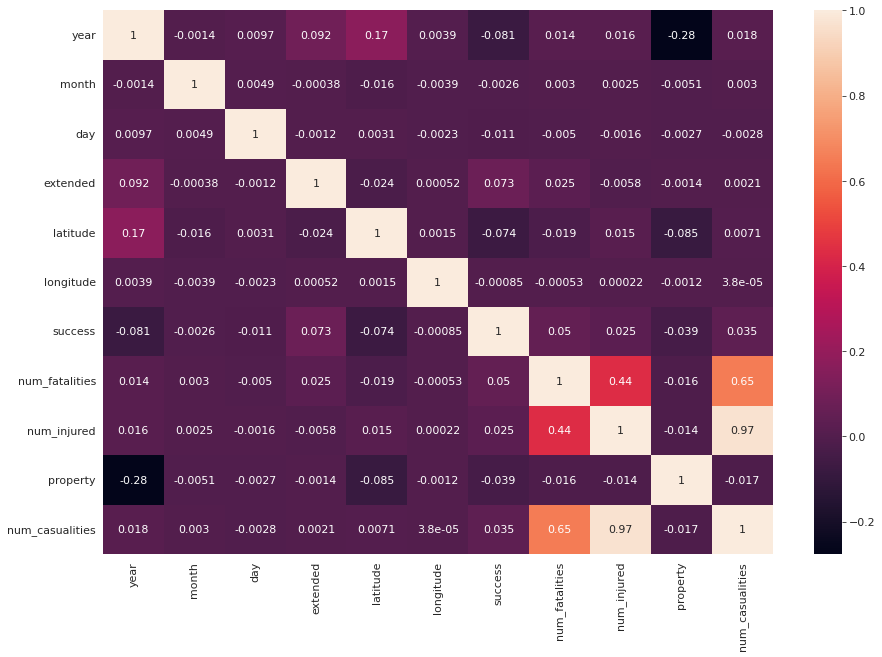

In [54]:
plt.figure(figsize=(15,10))
sns.heatmap(data_new.drop('eventid',axis = 1).corr(), annot= True)
plt.show()

## Exploratory Data Analysis & Visualizations

#### 1. No.of Successful and Not successful attacks per year

In [55]:
plt.rcParams['figure.figsize'] = (20, 5)
fig = px.histogram(data_new, 
                   x='year', 
                   color = 'success', 
                   color_discrete_sequence=['green', 'grey'], 
                   title='Number of terrorist attack per year')
fig.update_layout(bargap=0.1)
fig.update_xaxes(tickangle= -90)
fig.show()

#### 2. Distinct regions exist in the dataset & Affected top 20 affected countries

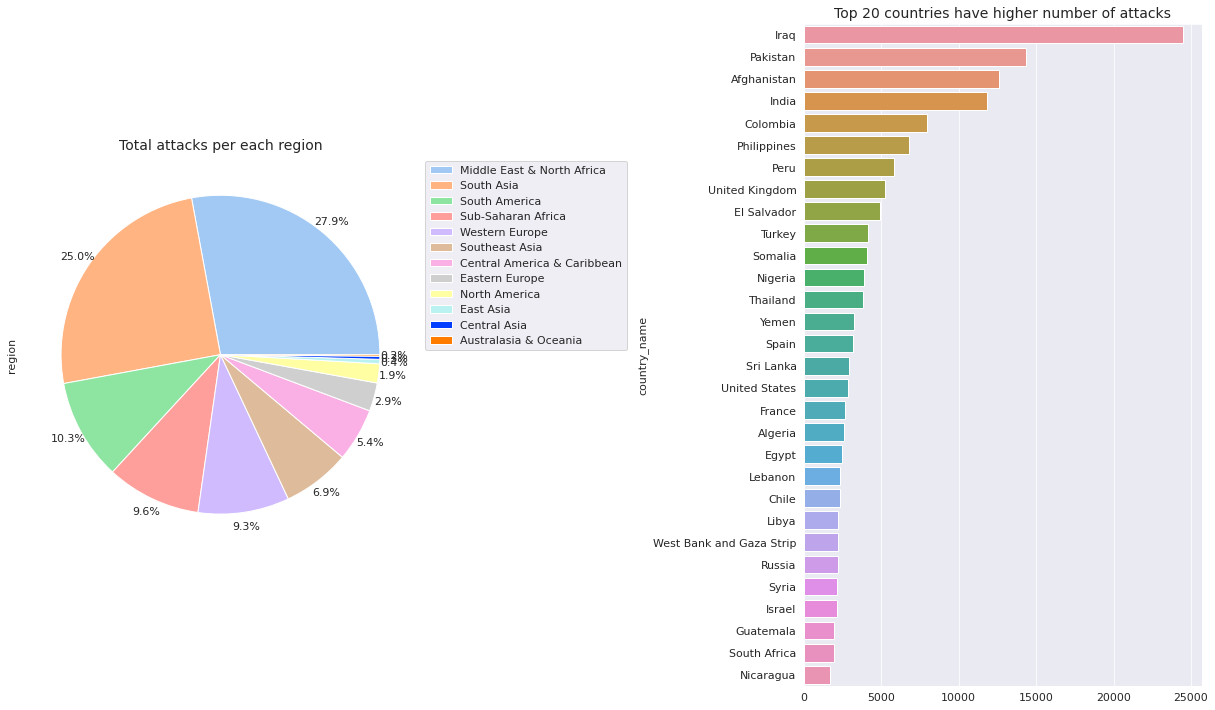

In [57]:
plt.figure(figsize=(17, 10))
ax1 = plt.subplot(121)
colors = sns.color_palette('pastel')[0:10]+sns.color_palette('bright')[0:2]
data_new.region.value_counts().plot(kind='pie',autopct="%.1f%%",pctdistance= 1.09, colors = colors,labels = None)
                                              # ,rotatelabels=True,labeldistance=1)
ax1.legend(labels =data_new.region.value_counts().index, bbox_to_anchor = (1,1),loc = 2)
ax1.set_title('Total attacks per each region',size = 14)
ax2 = plt.subplot(122)
sns.barplot(x =data_new.groupby('country_name').eventid.count().sort_values(ascending=False)[:30].values , 
            y = data_new.groupby('country_name').eventid.count().sort_values(ascending=False)[:30].index )
ax2.set_title('Top 20 countries have higher number of attacks',size = 14)
plt.tight_layout()
plt.show()

#### 3.Top 50 targeted cities in the history

<AxesSubplot:xlabel='city'>

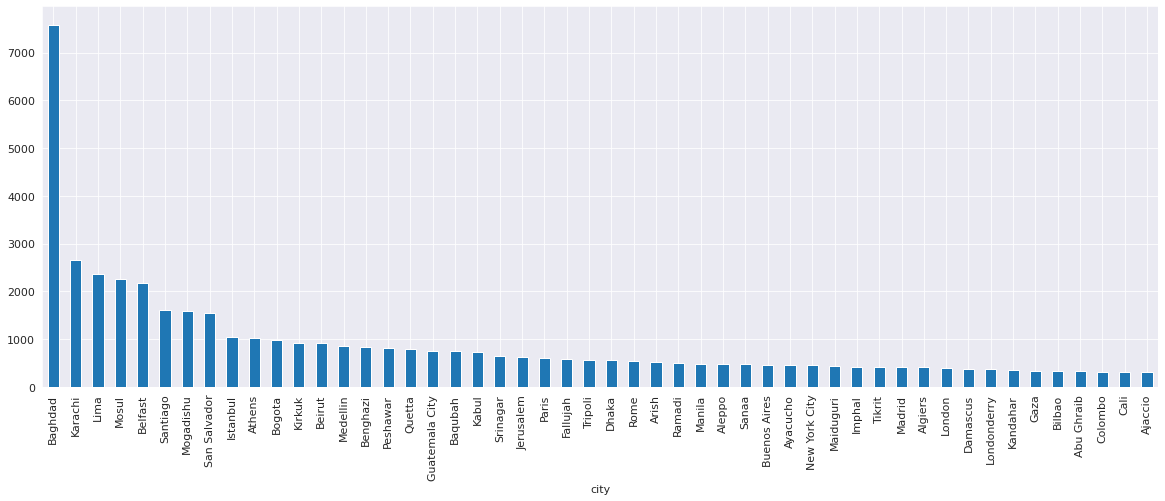

In [58]:
target_cities = data_new[data_new.city != 'Unknown'].groupby(['city'])['eventid'].count().sort_values(ascending= False)[:50]
target_cities.plot(kind ='bar',figsize=(20, 7))

#### a. Top active terrorist groups in Baghdad

In [59]:
baghdad_df = data_new[data_new.city == 'Baghdad']
baghdad_df.groupby('perpetrator_group')['eventid'].count().sort_values(ascending = False)[:10]

perpetrator_group
Unknown                                        6535
Islamic State of Iraq and the Levant (ISIL)     622
Al-Qaida in Iraq                                216
Islamic State of Iraq (ISI)                      57
Tawhid and Jihad                                 22
Gunmen                                           15
Mahdi Army                                       13
Sunni Muslim extremists                           8
Asa'ib Ahl al-Haqq                                8
Muslim extremists                                 8
Name: eventid, dtype: int64

#### b. Number of kills and injured and casualities per each year

<AxesSubplot:xlabel='year'>

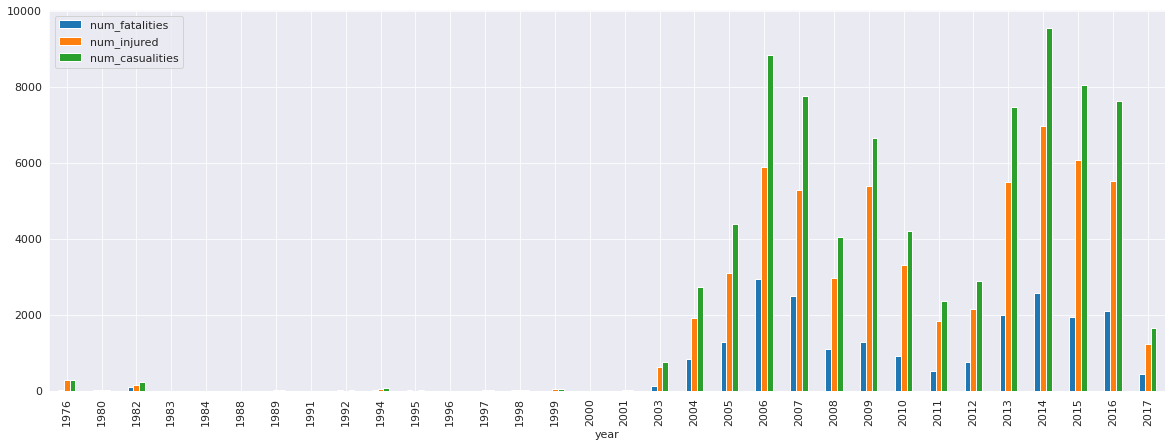

In [60]:
baghdad_casualities = baghdad_df.groupby('year')['num_fatalities','num_injured','num_casualities'].sum()
baghdad_casualities.plot(kind='bar',figsize=(20, 7))

https://www.vox.com/a/maps-explain-crisis-iraq

#### 4. The total num. of fatalities, injured and casualties by Region

In [57]:
data_by_region = data_new.groupby('region')['num_fatalities','num_injured','num_casualities'].sum()
data_by_region 

,num_fatalities,num_injured,num_casualities
region,,,
Australasia & Oceania,162.0,273.0,435.0
Central America & Caribbean,39847.0,13346.0,53193.0
Central Asia,1038.0,2017.0,3055.0
East Asia,1185.0,9260.0,10445.0
Eastern Europe,8337.0,12600.0,20937.0
Middle East & North Africa,144707.0,228474.0,373181.0
North America,5023.0,21650.0,26673.0
South America,39238.0,21529.0,60767.0
South Asia,103839.0,147010.0,250849.0


<AxesSubplot:title={'center':'The total num. of deaths, wounded and casualties by Region'}, xlabel='region'>

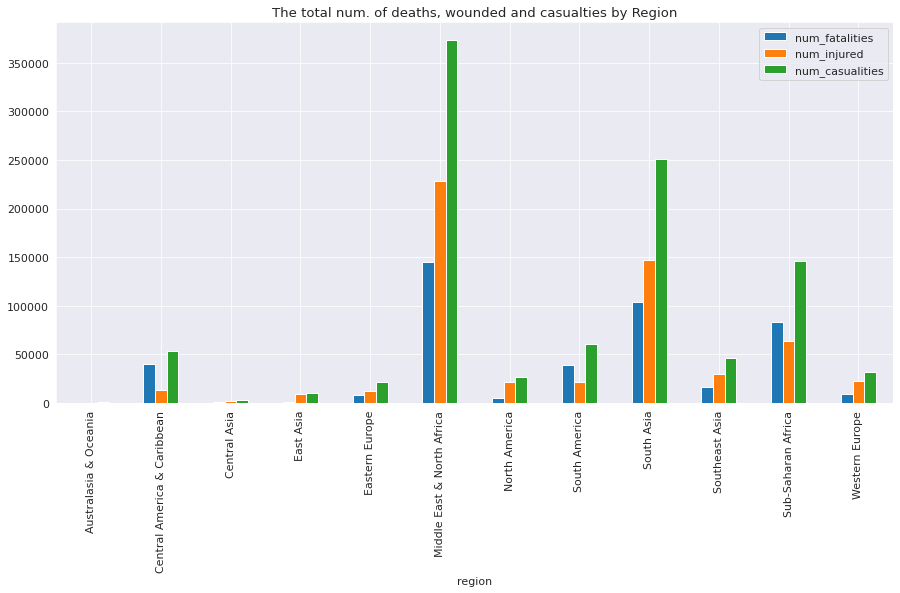

In [58]:
data_by_region.plot(kind = 'bar',figsize=(15, 7),
                    title = 'The total num. of deaths, wounded and casualties by Region')

### 5. Howmany distinct countries exist in each region of the dataset

In [82]:
region_country_df = data_new[['region','country_name']]
region_df = region_country_df.groupby('region').agg(set)

def count_counties(row):
  row['unique_country_count'] = len(row['country_name'])
  return row

region_df.apply(count_counties, axis = 1)

,country_name,unique_country_count
region,,
Australasia & Oceania,"{New Zealand, Australia, Fiji, Solomon Islands...",10
Central America & Caribbean,"{Dominican Republic, Martinique, Costa Rica, G...",21
Central Asia,"{Georgia, Turkmenistan, Tajikistan, Azerbaijan...",8
East Asia,"{China, South Korea, North Korea, Japan, Hong ...",7
Eastern Europe,"{Albania, Slovak Republic, Soviet Union, Slove...",26
Middle East & North Africa,"{Algeria, Tunisia, Saudi Arabia, Egypt, Israel...",23
North America,"{United States, Canada, Mexico}",3
South America,"{Chile, Ecuador, Bolivia, Uruguay, Guyana, Arg...",14
South Asia,"{Nepal, Sri Lanka, Bhutan, India, Maldives, Ma...",9


#### 6. Methodes of attacks by count 

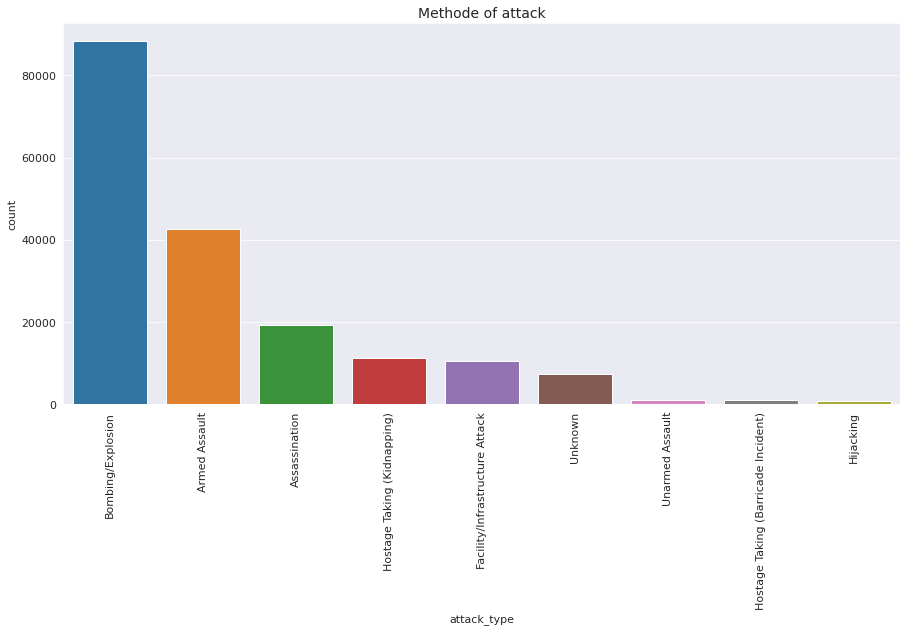

In [61]:
plt.rcParams['figure.figsize'] = (15, 7)
sns.countplot(x="attack_type", data= data_new, order=data_new.attack_type.value_counts().index)
plt.title('Methode of attack', size = 14)
plt.xticks(rotation=90)
plt.show()

#### 6. Victims of Terrorist attacks

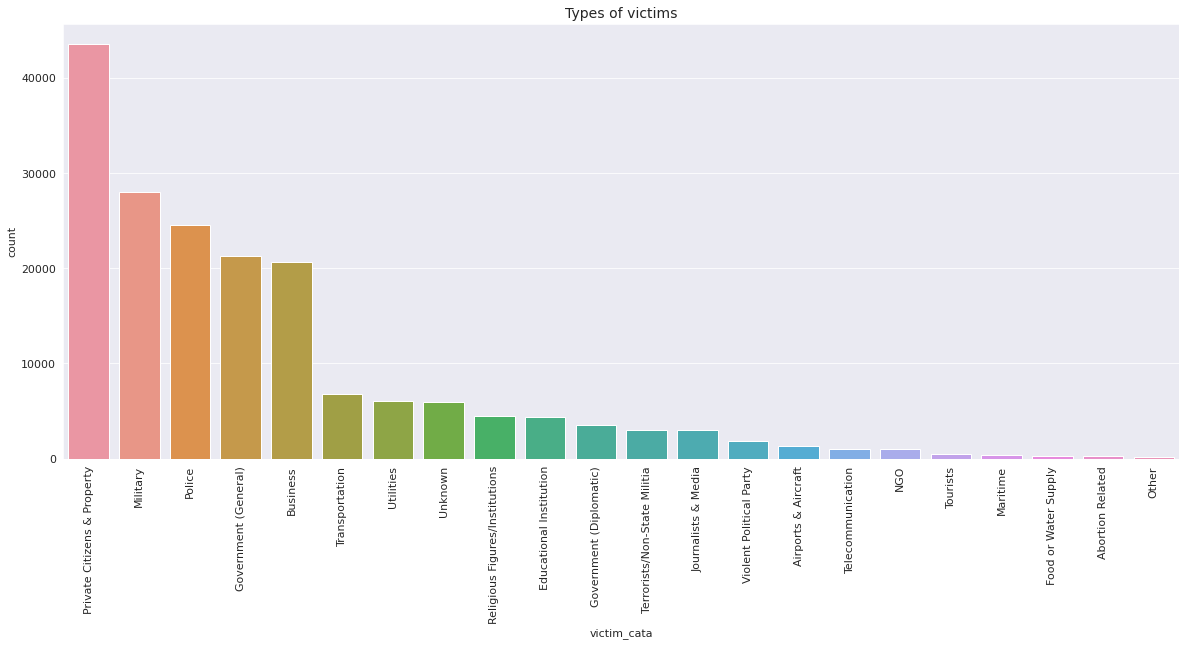

In [83]:
### types of victims of attack
plt.rcParams['figure.figsize'] = (20, 8)
sns.countplot(x="victim_cata", data= data_new, order=data_new.victim_cata.value_counts().index)
plt.title('Types of victims', size = 14)
plt.xticks(rotation=90)
plt.show()

In [84]:
data_new.columns

Index(['eventid', 'year', 'month', 'day', 'extended', 'country_name', 'region',
       'city', 'latitude', 'longitude', 'success', 'attack_type',
       'victim_cata', 'entity_name', 'specific_victim', 'victim_nationaliy',
       'victim_subtype_cata', 'perpetrator_group', 'weapon', 'num_fatalities',
       'num_injured', 'property', 'num_casualities'],
      dtype='object')

#### 7. Top 25 active terror groups

In [ ]:
data_new['perpetrator_group'].nunique()

In [ ]:
plt.rcParams['figure.figsize'] = (12, 10)
sns.barplot(data_new['perpetrator_group'].value_counts()[1:25].values,data_new['perpetrator_group'].value_counts()[1:25].index)
plt.title('Top 25 active terror groups', size = 14)
plt.show()

In [ ]:
Taliban_df = data_new[data_new.perpetrator_group == 'Taliban']
Taliban_df.groupby('country_name')['eventid'].count()

In [ ]:
ISIL_df = data_new[data_new.perpetrator_group == 'Islamic State of Iraq and the Levant (ISIL)']
ISIL_df.groupby('country_name')['eventid'].count().sort_values(ascending= False)

In [ ]:
active_groups = data_new[data_new.perpetrator_group != 'Unknown'].groupby('perpetrator_group').eventid.count().sort_values(ascending= False)
active_groups

In [ ]:
Taliban_df = data_new[data_new.perpetrator_group == 'Taliban']
Taliban_df.groupby('country_name')['eventid'].count()

In [ ]:
data_new[data_new['country_name']=='India']['perpetrator_group'].value_counts(ascending= False)[:10].plot(kind = 'bar')

In [ ]:
plt.rcParams['figure.figsize'] = (20, 5)
plt.title('Trends in Data (Understanding spikes)', size = 14)
data_new.groupby('year')['num_fatalities'].sum().plot()
data_new.groupby('year')['num_injured'].sum().plot()
data_new.groupby('year')['eventid'].count().plot()
data_new[data_new.property  == 1].groupby('year')['property'].sum().plot()

In [ ]:
extended_attack_df = data_new[data_new['extended'] == 1]
non_extended_attack_df = data_new[~ (data_new['extended'] == 1)]

In [ ]:
plt.figure(figsize=(20, 5))
ax1 = plt.subplot(121)
sns.barplot(extended_attack_df['attack_type'].value_counts().values,extended_attack_df['attack_type'].value_counts().index, color='blue')
ax1.set_title('Attack extended more than 24 hours ',size = 14)
ax2 = plt.subplot(122)
sns.barplot(non_extended_attack_df['attack_type'].value_counts().values,non_extended_attack_df['attack_type'].value_counts().index, color='green')
ax2.set_title('Attack not extended more than 24 hours ',size = 14)
plt.tight_layout()
plt.show()

In [ ]:
data_new.columns

In [ ]:
### top 10 countries faced higher property damage
property_damage = data_new[data_new.property  == 1] 

In [ ]:
property_damage.groupby('country_name')['property'].sum().sort_values(ascending  =False)